In [1]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq 
using BenchmarkTools

In [2]:
""" Prepare the initial vector u0 for MPC """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Prepare the initial vector u0 for MF """
function u0_CFunction_MF(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            print("Not a meanfield differential equation!")
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib_euler(chunk, f, op_list, N, n, d0_lb)
    popup_t, sol_t, t_euler = [], [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

         # Load the functions
        fsolve(du, u, p, t) = f(du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.Euler(), saveat=T;
                    reltol=1.0e-6,
                    abstol=1.0e-8, dt=tstep)
        
        print(SciMLBase.successful_retcode(sol))
        push!(t_euler, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(t_euler[end])])
        push!(sol_t, sol.u)
    end
    return popup_t, sol_t, t_euler
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib_euler_MF(chunk, f_MF, op_list, N, n, d0_lb)
    popup_t, sol_t, t_euler = [], [], []

    for i in chunk
        # Load atom distribution of MPC
        @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

         # Load the functions
        fsolve(du, u, p, t) = f_MF(du, u, p0)

        phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
        u0 = u0_CFunction_MF(phi_array_0, theta_array_0, op_list)

        prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
        sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.Euler(), saveat=T;
                    reltol=1.0e-6,
                    abstol=1.0e-8, dt=tstep)
        
        print(SciMLBase.successful_retcode(sol))
        push!(t_euler, sol.t)
        push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(t_euler[end])])
        push!(sol_t, sol.u)
    end
    return popup_t, sol_t, t_euler
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

""" Return the minimum distance of a distribution of atoms r0 """
function avg_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return mean(d0)*N/(N-1)
end

""" Reconstruct the position of atoms """
function reconstruct_img_distrib(N, i)
    @load "r0/r0_N_$(N)_r_$i.jdl2" r0 L
    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter([r[1] for r in r0], [r[2] for r in r0], [r[3] for r in r0])
    ax.set_xlabel(L"x/$\lambda$")
    ax.set_ylabel(L"y/$\lambda$")
    ax.set_zlabel(L"z/$\lambda$")
    ax.set_xlim(0, L), ax.set_ylim(0, L), ax.set_zlim(0, L)
    plt.savefig("Images_distribution/IImages_distribution_N_$(N)_r_$i")
end

reconstruct_img_distrib

### Define the system

In [3]:
# Nbr of particles
N = 4
r = 10 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 2e3 # atoms per unit of volume (already normalized)
d0_lb = 2e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb/λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 1e-4
T = [0:tstep:10;]; # Normalised time

### Compute stationnary state for r repetitions

In [4]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

# MPC

In [5]:
# Prepare the function
libpath ="libs/liballfuncs_$N.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f (generic function with 1 method)

In [6]:
@load "op_list/op_list_$N.jdl2" op_list
list_r = 1:r

# Solve with Euler
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
    Threads.@spawn solve_random_distrib_euler(chunk, f, op_list, N, n0, d0_lb)
end

# Gather the data from the different threads
sol_tasks = fetch.(tasks)
popup_t_euler, sol_t_euler, t_euler = vcat([s[1] for s in sol_tasks]...), vcat([s[2] for s in sol_tasks]...), vcat([s[3] for s in sol_tasks]...)

false

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:686


truetruetruetruefalse

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:686


truetruetruetrue

(Any[[1.4997597826618576e-32, 1.500479085397668e-32, 1.8703999850368214e-9, 5.610111729646769e-9, 1.1218021016226364e-8, 1.869298767142354e-8, 2.803384560306696e-8, 3.923940283763221e-8, 5.230844155824363e-8, 6.723971814321058e-8  …  0.002450063554796535, 0.002450060313492633, 0.002450057115701361, 0.0024500539613884, 0.002450050850519155, 0.002450047783058752, 0.002450044758972042, 0.0024500417782235993, 0.0024500388407777216, 0.002450035946598434], [1.4997597826618576e-32, 1.500660456803717e-32, 1.870399985036841e-9, 5.610090520863357e-9, 1.1217891665326922e-8, 1.8692553052985134e-8, 2.803275398253957e-8, 3.92371035070818e-8, 5.230414052714573e-8, 6.72323338865604e-8  …  3.6680500223015e-5, 3.6694200766611735e-5, 3.6707910134765106e-5, 3.6721628218101295e-5, 3.673535490718e-5, 3.674909009249541e-5, 3.6762833664477435e-5, 3.677658551349164e-5, 3.6790345529841764e-5, 3.680411360376958e-5], [1.4997597826618576e-32, 1.5013248355271528e-32, 1.870399985036783e-9, 5.610130344983149e-9, 1.12

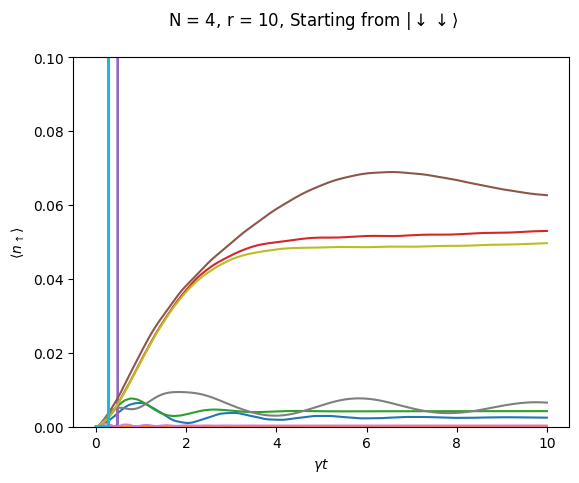

In [7]:
close("all")
fig, ax = subplots()
for i in 1:length(popup_t_euler)
    line, = ax.plot(t_euler[i], popup_t_euler[i])
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.set_ylim(0, 0.1)

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false);
# pygui(true); show()

# MF

In [8]:
# Prepare the function
libpath_MF ="libs/liballfuncs_$(N)_meanfield.dll"
f_MF(du, u, params) = ccall(("diffeqf", libpath_MF), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f_MF (generic function with 1 method)

In [9]:
@load "op_list/op_list_$(N)_meanfield.jdl2" op_list
list_r = 1:r

# Solve with Euler
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))
tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
    Threads.@spawn solve_random_distrib_euler_MF(chunk, f_MF, op_list, N, n0, d0_lb)
end

# Gather the data from the different threads
sol_tasks = fetch.(tasks)
popup_t_euler_MF, sol_t_euler_MF, t_euler_MF = vcat([s[1] for s in sol_tasks]...), vcat([s[2] for s in sol_tasks]...), vcat([s[3] for s in sol_tasks]...)

false

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:686


truetruetruetruefalsetruetruetruetrue

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:686


(Any[[1.4997597826618576e-32, 1.500479085397668e-32, 1.870130763214842e-9, 5.60930429828057e-9, 1.121640663444548e-8, 1.8690297857945027e-8, 2.8029812148914348e-8, 3.923375781883717e-8, 5.230091734852985e-8, 6.723004742665938e-8  …  0.0024692078935614954, 0.0024691987780291243, 0.002469189705843866, 0.0024691806769815455, 0.002469171691417696, 0.0024691627491275608, 0.0024691538500860918, 0.002469144994267954, 0.0024691361816475198, 0.0024691274121988755], [1.4997597826618576e-32, 1.500660456803717e-32, 1.8701236936203717e-9, 5.609261885179487e-9, 1.121623488848165e-8, 1.868979261141009e-8, 2.8028614643335713e-8, 3.923131034533584e-8, 5.229641894321702e-8, 6.722240962333588e-8  …  3.3890735866848625e-5, 3.390432892485439e-5, 3.391793096502601e-5, 3.393154188004024e-5, 3.3945161562509174e-5, 3.395878990498116e-5, 3.397242679994196e-5, 3.3986072139814714e-5, 3.399972581696228e-5, 3.401338772368719e-5], [1.4997597826618576e-32, 1.5013248355271528e-32, 1.870136968326969e-9, 5.6093415206024

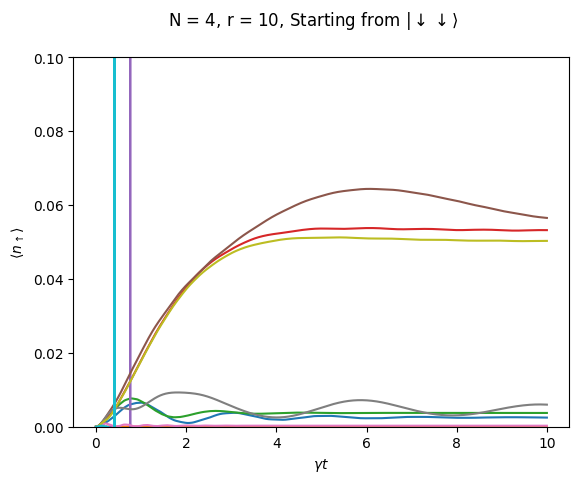

In [10]:
close("all")
fig, ax = subplots()
for i in 1:length(popup_t_euler_MF)
    line, = ax.plot(t_euler_MF[i], popup_t_euler_MF[i])
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.set_ylim(0, 0.1)

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false);
# pygui(true); show()

# Compare MF/MPC

In [15]:
close("all")
fig, ax = subplots()
for i in 1:length(popup_t_euler_MF)
    line, = ax.plot(t_euler[i], popup_t_euler[i], label="MPC")
    line_MF, = ax.plot(t_euler_MF[i], popup_t_euler_MF[i], linestyle="--", color=line.get_color(), label="MF")
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")
ax.legend()
ax.set_ylim(0, 0.1)

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
# pygui(false);
pygui(true); show()